In [1]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 710.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Global dictionary for encoding the chess pieces:
ENCODE = {'p':1, 'P':2, 'r':3, 'R':4, 'b':5, 'B':6, 'n':7, 'N':8, 'k': 9, 'K':10, 'q':11, 'Q':12}
DECODE = {v: k for k, v in ENCODE.items()}

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import sys
import glob
from random import shuffle
import chess
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D

# **DATA EXPLORATION**

In [4]:
train = glob.glob("/kaggle/input/chess-positions/dataset/train/*.jpeg")
test = glob.glob("/kaggle/input/chess-positions/dataset/test/*.jpeg")

# Get FEN from file names:

In [5]:
def fen_from_filename(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0].replace('-','/')

In [6]:
# Test the function
fen_from_filename(train[0])

'n2q1QB1/N5pb/8/8/3Q4/4k2b/b2rP3/3K3n'

# Plotting Train images:

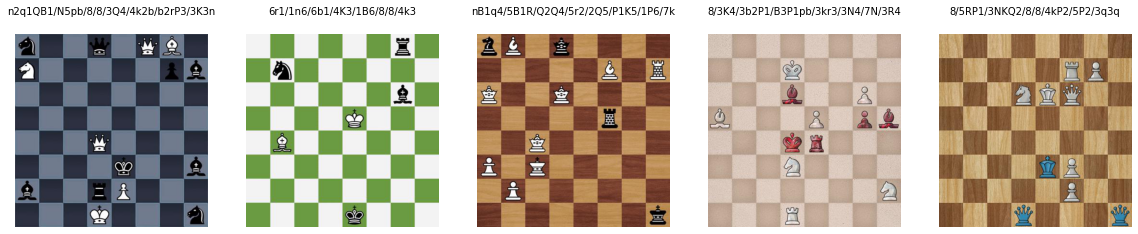

In [7]:
f, axarr = plt.subplots(1,5, figsize=(20, 30))
for i in range(5):
    axarr[i].set_title(fen_from_filename(train[i]), fontsize=10, pad=20)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

# Check the label with python-chess library:

In [8]:
board = chess.Board(fen_from_filename(train[0]))

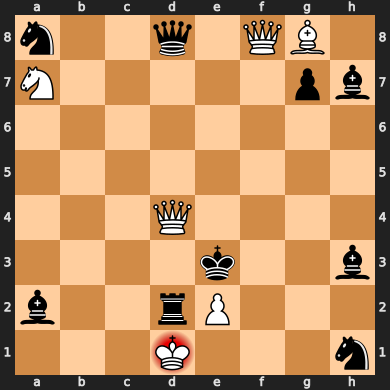

In [9]:
board

We can see that the board is identical.

However we also see that the board is not a valid one because two kings cannot be in check at the same time.

# Image analysis

In [10]:
img = mpimg.imread(train[0])
img.shape

(400, 400, 3)

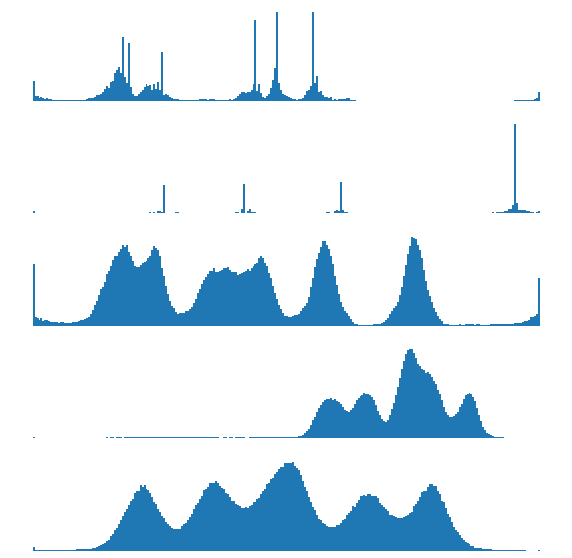

In [11]:
f, axarr = plt.subplots(5,1, figsize=(10,10))
for i in range(5):
    img = mpimg.imread(train[i])
    axarr[i].hist(img.ravel(),256,[0,256])
    axarr[i].axis('off')

The each images have very different histogram because of different design in chess board and chess pieces colors.
We can try histogram equalization to normalize the data.

# Histogram equalization with OpenCV

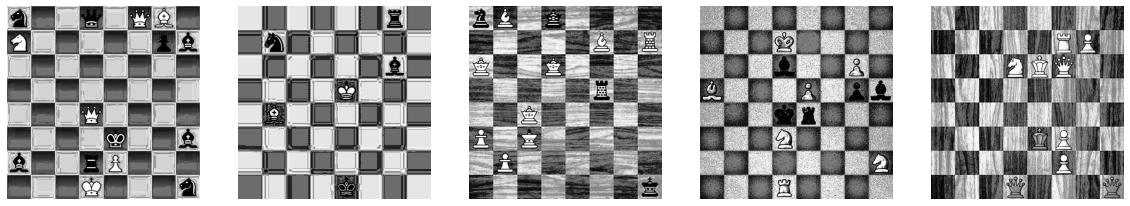

In [12]:
f, axarr = plt.subplots(1,5, figsize=(20, 30))
for i in range(5):
    image = mpimg.imread(train[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    equalized = np.stack((equalized,)*3, axis=-1)
    axarr[i].imshow(equalized)
    axarr[i].axis('off')

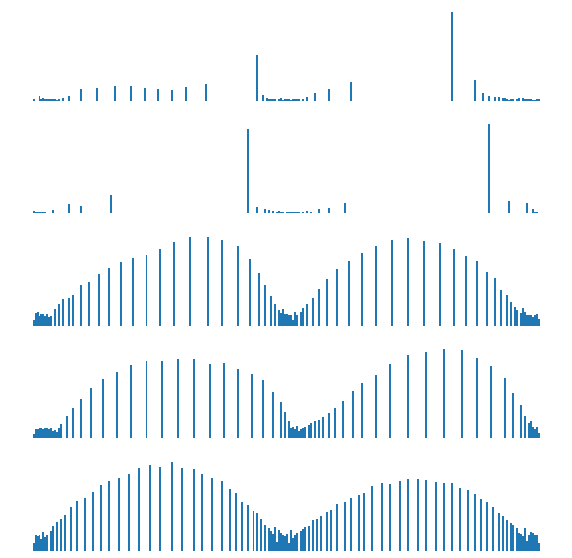

In [13]:
f, axarr = plt.subplots(5,1, figsize=(10,10))
for i in range(5):
    image = mpimg.imread(train[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    axarr[i].hist(equalized.ravel(),256,[0,256])
    axarr[i].axis('off')

The histogram actually not helping very much since it reduces information dimension, making harder to distinguish the piece from the board, especially the black pieces on black squares.

# Filtering

We want to reduces noise come from the squareboard texture while enhancing the edges of chess pieces. For this reason Bilateral Filter and Filter for Sharpen Edge is the suitable option. By setting the diameter of the filter according to the square size, we can remove the noise from chessboard.

In [14]:
def sharpen(image):
    kernel = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
    sharpenedImage = cv2.filter2D(image, -1, kernel)
    return sharpenedImage

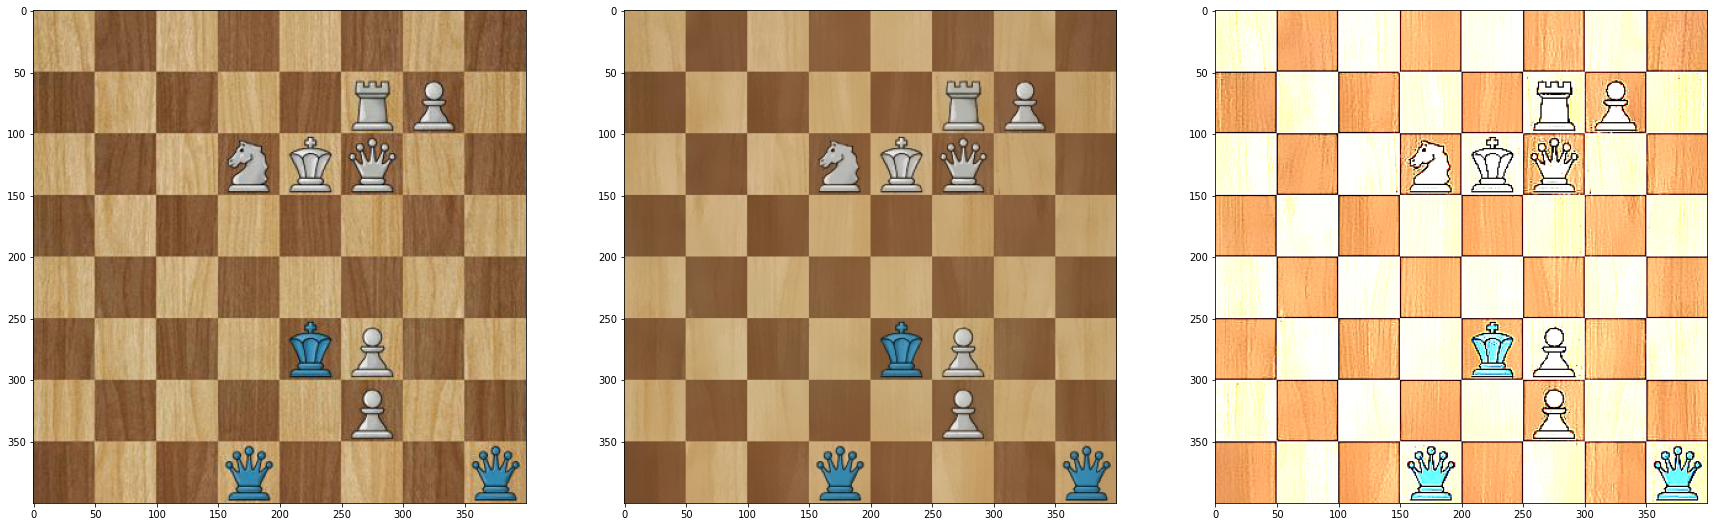

In [15]:
f, axarr = plt.subplots(1,3, figsize=(30, 30))
image = mpimg.imread(train[4])

img=cv2.bilateralFilter(image,20,40,50)
sharp = sharpen(img)
axarr[0].imshow(image)
axarr[1].imshow(img)
axarr[2].imshow(sharp)
    
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #equalized = cv2.equalizeHist(gray)
    #equalized = np.stack((equalized,)*3, axis=-1)

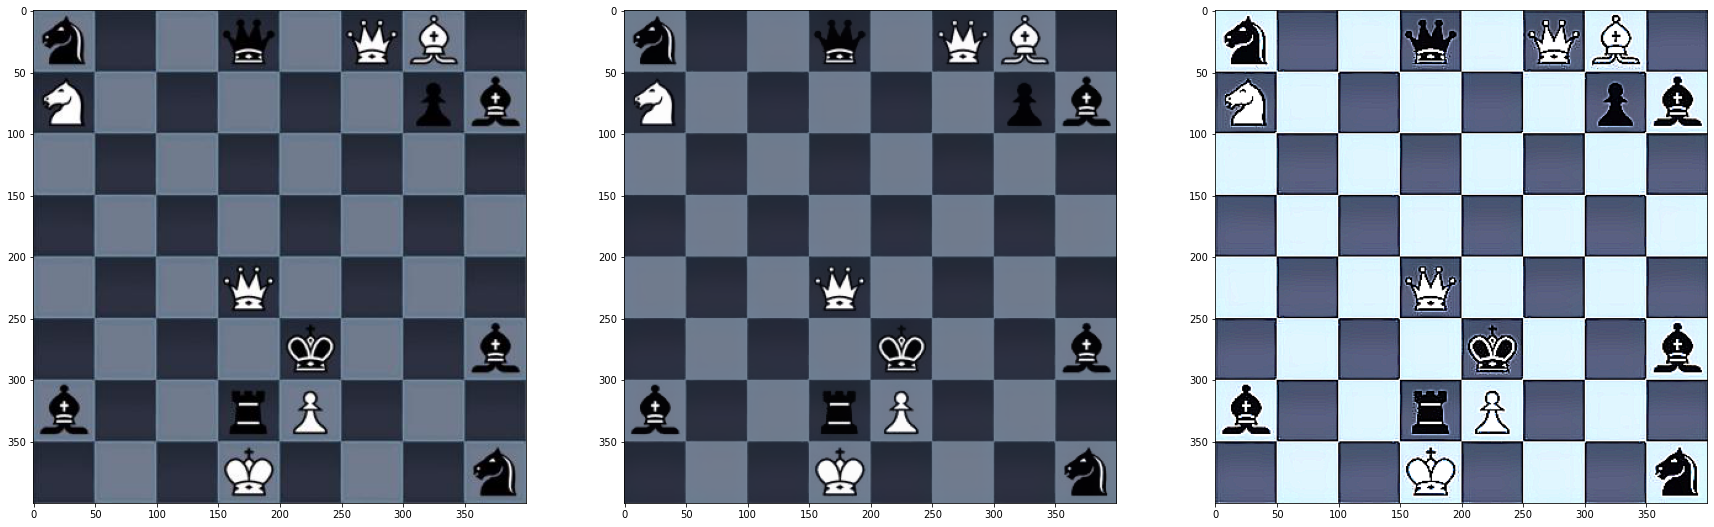

In [16]:
f, axarr = plt.subplots(1,3, figsize=(30, 30))
image = mpimg.imread(train[0])

img=cv2.bilateralFilter(image,20,40,50)
sharp = sharpen(img)
axarr[0].imshow(image)
axarr[1].imshow(img)
axarr[2].imshow(sharp)

# Get images of each squares:

In [17]:
def get_square_images(filepath):
    square_img = []
    image = mpimg.imread(filepath)
    
    # Applying Bilateral Filter
    #image=cv2.bilateralFilter(image,20,40,50)
    
    # Applying Sharpen Filter
    kernel = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
    sharp_img = cv2.filter2D(image, -1, kernel)
    
    # reduce the size of image:
    downsample_size = 200
    image = transform.resize(sharp_img, (downsample_size, downsample_size), mode='constant')
    
    # Cut the pictures into 64 squares
    cut_size = 25
    for i in range(8):
        for j in range(8):
            square_img.append(image[cut_size*i:cut_size*(i+1),cut_size*j:cut_size*(j+1)])

    square_img = np.array(square_img)

    return square_img

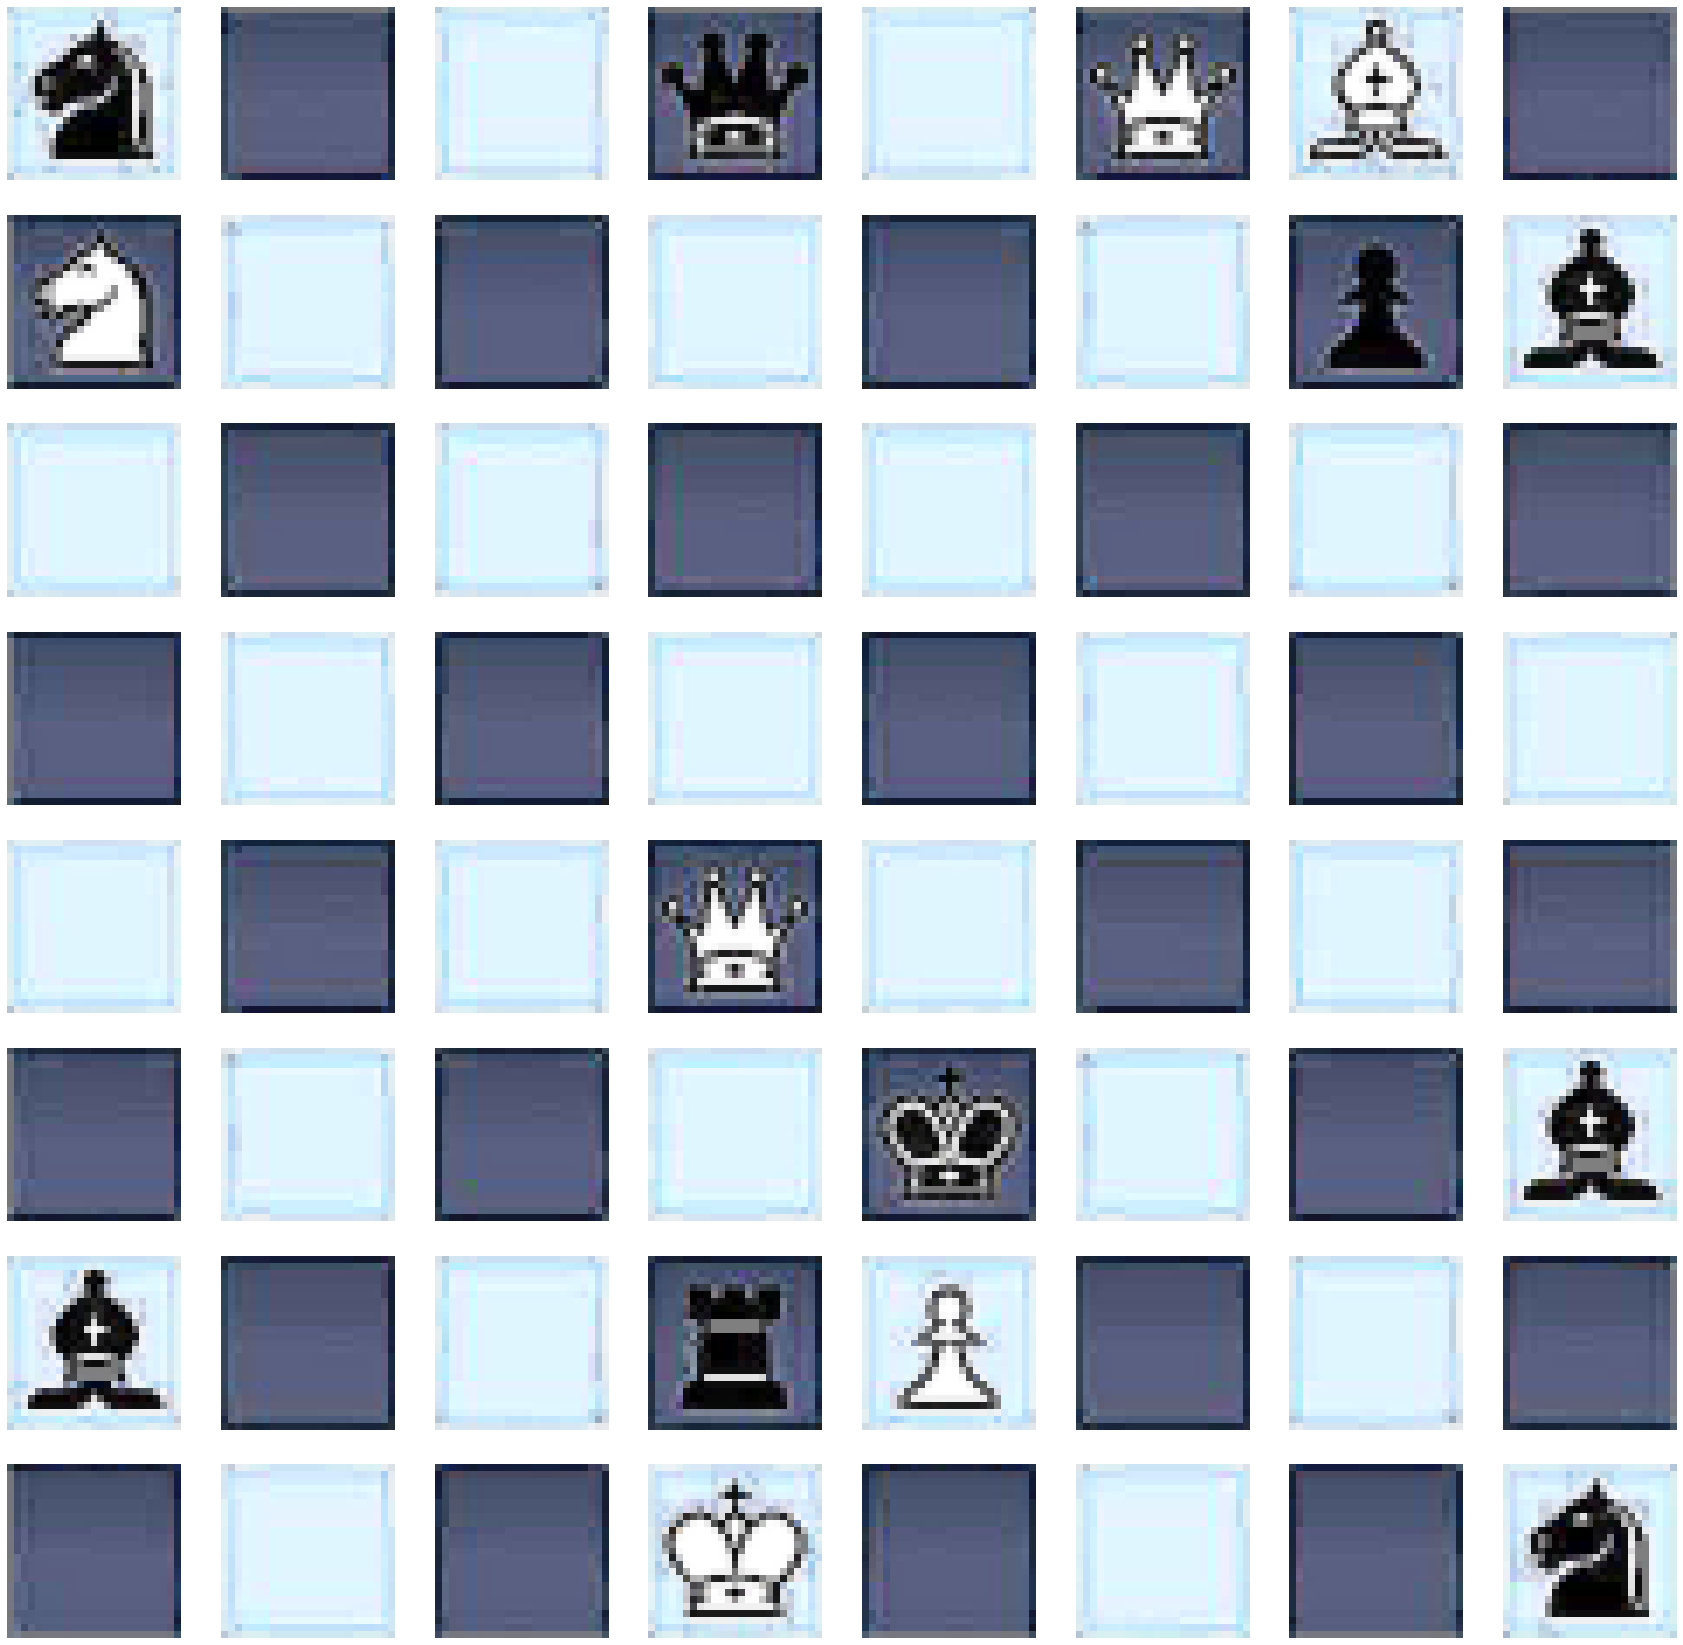

In [18]:
# TEST GET SQUARE IMAGE FUNCTION
test_sqr = get_square_images(train[0])
f1, axarr1 = plt.subplots(8,8, figsize=(30, 30))
for i in range(8):
    for j in range(8):
        axarr1[i,j].imshow(test_sqr[i*8+j])
        axarr1[i,j].axis('off')

# Label-Encoding from FEN:

In [19]:
def get_square_labels(filepath):
    ENCODE = {'p':1, 'P':2, 'r':3, 'R':4, 'b':5, 'B':6, 
              'n':7, 'N':8, 'k': 9, 'K':10, 'q':11, 'Q':12}
    y = []
    lines = fen_from_filename(filepath).split('/')
    for line in lines:
        for char in line:
            code = np.zeros(13)
            if(char in '12345678'):
                for _ in range(int(char)):
                    code[0] = 1
                    y.append(code)
            else:
                code[ENCODE[char]]=1
                y.append(code)
    return np.array(y)

# **Model Training**

In [20]:
cut_size = 25
model = Sequential()
# Add a convolutional layer
model.add(Convolution2D(15, kernel_size=3, activation='relu', 
                 input_shape=(cut_size, cut_size, 3)))


# Add a pooling operation
model.add(MaxPool2D(2))

# Add another convolutional layer
model.add(Convolution2D(10, kernel_size=3, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
# Add a dropout layer
model.add(Dropout(0.3))
model.add(Dense(13, activation='softmax'))
model.summary()

2022-08-04 14:34:21.195902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 14:34:21.353404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 14:34:21.357365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 14:34:21.362953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 15)        420       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 10)          1360      
_________________________________________________________________
flatten (Flatten)            (None, 810)               0         
_________________________________________________________________
dropout (Dropout)            (None, 810)               0         
_________________________________________________________________
dense (Dense)                (None, 13)                10543     
Total params: 12,323
Trainable params: 12,323
Non-trainable params: 0
____________________________________________________

In [21]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Use preprocessing function to save memory:

In [22]:
def train_gen(filepaths):
    shuffle(filepaths)
    for filepath in filepaths:
        x = get_square_images(filepath)
        y = get_square_labels(filepath)
        yield x, y

def valid_gen(filepaths, he=False):
    shuffle(filepaths)
    for filepath in filepaths[:32]:
        x = get_square_images(filepath)
        y = get_square_labels(filepath)
        yield x, y
        
        
def pred_gen(filepaths, he=False):
    for filepath in filepaths:
        yield get_square_images(filepath)

Train model with normal histogram

In [23]:
history = model.fit(train_gen(train),steps_per_epoch=128, epochs=10)

2022-08-04 14:34:25.772809: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-04 14:34:27.528379: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 12s 32ms/step - loss: 0.7359 - accuracy: 0.8278
Epoch 2/10
128/128 [==============================] - 4s 32ms/step - loss: 0.3884 - accuracy: 0.8939
Epoch 3/10
128/128 [==============================] - 5s 36ms/step - loss: 0.2058 - accuracy: 0.9423
Epoch 4/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1467 - accuracy: 0.9604
Epoch 5/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0976 - accuracy: 0.9733
Epoch 6/10
128/128 [==============================] - 4s 35ms/step - loss: 0.0793 - accuracy: 0.9780
Epoch 7/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0724 - accuracy: 0.9808
Epoch 8/10
128/128 [==============================] - 5s 38ms/step - loss: 0.0499 - accuracy: 0.9883
Epoch 9/10
128/128 [==============================] - 4s 32ms/step - loss: 0.0555 - accuracy: 0.9849
Epoch 10/10
128/128 [==============================] - 4s 32ms/step - loss: 0.0459 - accuracy: 0.9857

# Inference Function:

In [24]:
def get_pred_from_file(filename, model):
    x_train=np.array(get_square_images(filename))
    y_pred = model.predict(x_train)
    return np.argmax(y_pred, axis=1)

def get_fen_from_pred(y_pred):
    output = ''
    for j in range(8):
        for i in range(8):
            if(y_pred[j*8+i] == 0):
                output += ' '
            else:
                output += DECODE[y_pred[j*8+i]]
        if(j != 7):
            output += '-'
    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))
    return output

def predict_FEN(filename, model):
    y_pred = get_pred_from_file(filename, model)
    return get_fen_from_pred(y_pred)

In [25]:
print("predicted label: ",predict_FEN(train[0], model))
print("true label     : ",os.path.basename(train[0])[:-5])

predicted label:  5N2-2N1K2B-4b3-RK3Q2-2PB3B-2B5-R7-8
true label     :  5n2-2n1k2B-4b3-RK3Q2-2PB3b-2b5-R7-8


# Model Evaluation

In [26]:
def evaluation_with_error_types(test, size=100, visual=False):
    count = 0
    c = 0
    pb = 0
    pp = 0
    bp = 0
    shuffle(test)
    for i in range(size):
        base = os.path.basename(test[i])[:-5]
        fen_pred = predict_FEN(test[i], model)
        if base != fen_pred:
            if base.lower() == fen_pred.lower():
                c +=1
                print("Error at :",i, " Type: Color")
            elif len(base) > len(fen_pred):
                pb +=1
                print("Error at :",i, " Type: Piece-to-Board")
            elif len(base) == len(fen_pred):
                pp +=1
                print("Error at :",i, " Type: Piece-to-Piece")
            else:
                bp +=1
                print("Error at :",i, " Type: Board-to-Piece")
            if visual:
                print(base)
                print(fen_pred)
                plt.imshow(mpimg.imread(test[i]))
                plt.show()
            count +=1

    print("Error rate: {}%".format(count/size*100))
    print("Color error: {}%, make up for {}% total error".format(c/size*100, c/count*100))
    print("Piece-to-Board error: {}%, make up for {}% total error".format(pb/size*100, pb/count*100))
    print("Board-to-Piece error: {}%, make up for {}% total error".format(bp/size*100, bp/count*100))
    print("Piece-to-Piece error: {}%, make up for {}% total error".format(pp/size*100, pp/count*100))

In [27]:
evaluation_with_error_types(test, size=100)

Error at : 1  Type: Piece-to-Board
Error at : 2  Type: Color
Error at : 9  Type: Piece-to-Board
Error at : 12  Type: Piece-to-Piece
Error at : 31  Type: Piece-to-Piece
Error at : 35  Type: Piece-to-Piece
Error at : 36  Type: Piece-to-Piece
Error at : 40  Type: Piece-to-Board
Error at : 55  Type: Piece-to-Board
Error at : 60  Type: Color
Error at : 69  Type: Piece-to-Piece
Error at : 76  Type: Piece-to-Piece
Error at : 77  Type: Color
Error at : 81  Type: Piece-to-Piece
Error at : 84  Type: Color
Error at : 91  Type: Piece-to-Piece
Error at : 93  Type: Piece-to-Piece
Error at : 94  Type: Piece-to-Piece
Error at : 96  Type: Piece-to-Piece
Error at : 97  Type: Piece-to-Piece
Error at : 99  Type: Color
Error rate: 21.0%
Color error: 5.0%, make up for 23.809523809523807% total error
Piece-to-Board error: 4.0%, make up for 19.047619047619047% total error
Board-to-Piece error: 0.0%, make up for 0.0% total error
Piece-to-Piece error: 12.0%, make up for 57.14285714285714% total error


The result is logical considering we has just train the model on only 1280 pictures.
We continues to train to see if the error going down:

In [28]:
model.fit(train_gen(train),steps_per_epoch=128, epochs=10)

Epoch 1/10
128/128 [==============================] - 4s 35ms/step - loss: 0.0353 - accuracy: 0.9895
Epoch 2/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0455 - accuracy: 0.9879
Epoch 3/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0351 - accuracy: 0.9904
Epoch 4/10
128/128 [==============================] - 5s 39ms/step - loss: 0.0437 - accuracy: 0.9890
Epoch 5/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0312 - accuracy: 0.9912
Epoch 6/10
128/128 [==============================] - 4s 34ms/step - loss: 0.0204 - accuracy: 0.9939
Epoch 7/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0304 - accuracy: 0.9917
Epoch 8/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0217 - accuracy: 0.9941
Epoch 9/10
128/128 [==============================] - 4s 34ms/step - loss: 0.0200 - accuracy: 0.9944
Epoch 10/10
128/128 [==============================] - 4s 31ms/step - loss: 0.0228 - accura

In [29]:
test = glob.glob("/kaggle/input/chess-positions/dataset/test/*.jpeg")
evaluation_with_error_types(test, size=100)

Error at : 4  Type: Piece-to-Piece
Error at : 6  Type: Color
Error at : 8  Type: Piece-to-Piece
Error at : 26  Type: Color
Error at : 29  Type: Color
Error at : 37  Type: Piece-to-Piece
Error at : 40  Type: Piece-to-Piece
Error at : 44  Type: Piece-to-Piece
Error at : 45  Type: Color
Error at : 49  Type: Color
Error at : 52  Type: Piece-to-Board
Error at : 56  Type: Color
Error at : 97  Type: Piece-to-Piece
Error at : 98  Type: Color
Error rate: 14.000000000000002%
Color error: 7.000000000000001%, make up for 50.0% total error
Piece-to-Board error: 1.0%, make up for 7.142857142857142% total error
Board-to-Piece error: 0.0%, make up for 0.0% total error
Piece-to-Piece error: 6.0%, make up for 42.857142857142854% total error


In [30]:
model.save('/kaggle/working/')

2022-08-04 14:36:16.269245: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
